In [1]:
from cdlib.algorithms.internal.scan import SCAN_nx
from itertools import combinations

import networkx as nx
import pandas as pd
import JaroWinkler

# Initializing the Graph

In [2]:
# Values are as per the white paper

G = nx.Graph()

G.add_nodes_from([
    (1, {"name": "C. Chen", "short_name" : "P", "publications" : ["P5"]}),
    (2, {"name": "Chang Chen", "short_name" : "A", "publications" : ["P1","P2","P3","P4"]}),
    (3, {"name": "Tasawar Ali", "short_name" : "E", "publications" : ["P2"]}),
    (4, {"name": "F. Ali", "short_name" : "F", "publications" : ["P3"]}),
    (5, {"name": "M. Ibrahim", "short_name" : "G", "publications" : ["P3"]}),
    (6, {"name": "Farman Ali", "short_name" : "B", "publications" : ["P4"]}),
    (7, {"name": "Shakeel Ali", "short_name" : "D", "publications" : ["P4"]}),
    (8, {"name": "M. Rehan", "short_name" : "C", "publications" : ["P4"]})
])

G.add_edges_from([(1,8),(2,8),(2,3),(6,8),(7,8),(6,7),(2,7),(2,4),(2,5),(4,5)])

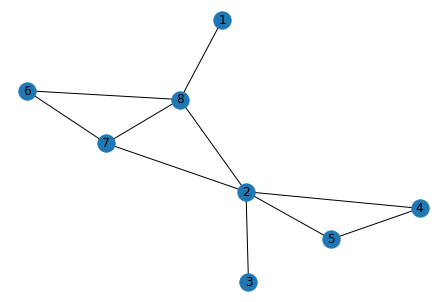

In [3]:
nx.draw(G, with_labels=True)

# Executing the SCAN algorithm to generate communities, hubs and outliers

In [4]:
CG = SCAN_nx(G, epsilon=0.7, mu=2)
communities = CG.execute()
hubs, outliers = CG.get_hubs_outliers(communities)

In [5]:
print(communities)

[[4, 2, 5], [7, 8, 6]]


In [6]:
print(hubs)

[]


In [7]:
print(outliers)

[1, 3]


In [8]:
# Changing the SCAN results for POC as sample data is insufficient for all test-cases

clusters = [{'hubs' : [2], 'cores' : [4,5]}, {'hubs' : [2], 'cores' : [1,6,8,7]}]

In [9]:
# Retrieving attributes for later use as a lookup table

document = nx.get_node_attributes(G,'publications')
name = nx.get_node_attributes(G,'name')
short_name = nx.get_node_attributes(G,'short_name')

# This is where Homonym Resolver starts

In [10]:
def homonym_resolver(community: list) -> list:
    """
    To split cluster of nodes based off the hubs between communities
    """
    print("Starting for new community...")
    
    new_cluster = {'hubs' : [], 'cores' : set()}
    all_documents = list()
    
    # Getting a list of all community members (Core nodes & Hub nodes)
    community_members = set(community['hubs']).union(set(community['cores']))

    # Creating a non-unique master list for all documents published in this community
    for member in community_members:
        all_documents.extend(document[member])

    # The below process will now create a new node for every hub in the community
    # that share only the documents which are present elsewhere in the community
    for hub in community['hubs']:
        
        # Getting the list of documents present in the community after removing 1-copy of each hub document
        all_documents_minus_hub = all_documents
        for hub_doc in document[hub]:
            all_documents_minus_hub.remove(hub_doc) # .remove() is used to remove only 1-copy

        # Creating new node with only those documents which are common with the community
        new_node_doc = list(set(document[hub]) & set(all_documents_minus_hub))
        new_node_id = G.number_of_nodes()+1
        new_node_name = name[hub]
        new_short_name = short_name[hub] + str(new_node_id)
        G.add_node(new_node_id, name=new_node_name, short_name=new_short_name, publications=new_node_doc)
        
        # Creating new node edges
        neighbor_list = list(iter(G.neighbors(hub)))
        for neighbor in neighbor_list:
            if neighbor in community_members:
                print(f'Adding edge between {new_node_id} and {neighbor}')
                G.add_edge(new_node_id, neighbor)
                print(f'Removing edge between {hub} and {neighbor}')
                G.remove_edge(hub, neighbor)
        
        # Removing current community-specific documents from original hub node
        attrs = {hub: {'publications': list(set(document[hub]).difference(set(new_node_doc)))}}
        nx.set_node_attributes(G, attrs)
        
    return nx.node_connected_component(G, new_node_id)           

In [11]:
new_clusters = list()
for community in clusters:
    new_clusters.append(homonym_resolver(community))
    document = nx.get_node_attributes(G,'publications') # Refreshing the document look-up

Starting for new community...
Adding edge between 9 and 4
Removing edge between 2 and 4
Adding edge between 9 and 5
Removing edge between 2 and 5
Starting for new community...
Adding edge between 10 and 8
Removing edge between 2 and 8
Adding edge between 10 and 7
Removing edge between 2 and 7


In [12]:
new_clusters # These represent the new node clusters

[{4, 5, 9}, {1, 6, 7, 8, 10}]

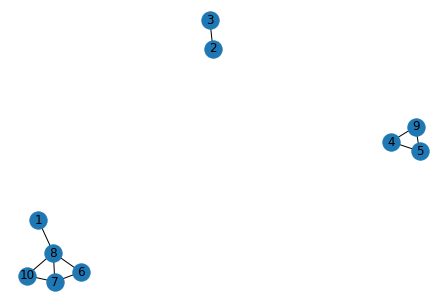

In [13]:
nx.draw(G, with_labels=True)

# Generating intermediate file containing Homonym index

In [14]:
graph_df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

In [15]:
graph_df.head(10)

,name,short_name,publications,classified,type
1,C. Chen,P,[P5],NaN,NaN
2,Chang Chen,A,"[P2, P1]",True,NaN
3,Tasawar Ali,E,[P2],NaN,NaN
4,F. Ali,F,[P3],True,core
5,M. Ibrahim,G,[P3],True,NaN
6,Farman Ali,B,[P4],True,NaN
7,Shakeel Ali,D,[P4],True,core
8,M. Rehan,C,[P4],True,NaN
9,Chang Chen,A9,[P3],NaN,NaN
10,Chang Chen,A10,[P4],NaN,NaN


In [16]:
graph_df_with_index = graph_df.drop(['short_name','classified','type'], axis=1).reset_index(drop=True)
graph_df_with_index['homonym_network_index'] = graph_df.reset_index().index

disambiguated_df_homonym_only = graph_df_with_index.explode('publications').reset_index(drop=True)

In [17]:
disambiguated_df_homonym_only.head(50)

,name,publications,homonym_network_index
0,C. Chen,P5,0
1,Chang Chen,P2,1
2,Chang Chen,P1,1
3,Tasawar Ali,P2,2
4,F. Ali,P3,3
5,M. Ibrahim,P3,4
6,Farman Ali,P4,5
7,Shakeel Ali,P4,6
8,M. Rehan,P4,7
9,Chang Chen,P3,8


# This is where the Synonym Resolver starts

In [18]:
# Refreshing attribute lookup indexs for synonym stage

document = nx.get_node_attributes(G,'publications')
name = nx.get_node_attributes(G,'name')
short_name = nx.get_node_attributes(G,'short_name')

In [19]:
def check_compatibility(first_name: str, second_name: str) -> bool:
    """
    To check if two names are compatible (i.e. they are a subset of each other or share common initials)
    """
    first_name = first_name.lower()
    second_name = second_name.lower()
    
    if first_name in second_name or second_name in first_name: # If names are sub-set of each other
        return True
    else:
        first_name_fi = first_name.split()[0][0]
        first_name_li = first_name.split()[-1][0]
        
        second_name_fi = second_name.split()[0][0]
        second_name_li = second_name.split()[-1][0]
        
        return (first_name_fi + ' ' + first_name_li)==(second_name_fi + ' ' + second_name_li) # If names share initials

In [20]:
def synonym_resolver(community: set) -> list:
    """
    Method to resolve synonymous authors within a community
    """
    deleted_nodes = list()
    
    # Checking the name compatibility, geodesic distance 
    # and Jaro-Winkler fuzzy score for every pair of nodes
    for node1, node2 in combinations(community, 2):
        if check_compatibility(name[node1], name[node2]) \
        and nx.shortest_path_length(G, source=node1, target=node2) < 3 \
        and JaroWinkler.jaro_distance(name[node1], name[node2]) >= 0.75:
            kept_node, deleted_node = merge_nodes(node1, node2)
            print(f"Node {deleted_node} has merged into node {kept_node}")
            deleted_nodes.append(deleted_node)
            
    return deleted_nodes

In [21]:
def merge_nodes(node1: int, node2: int) -> tuple:
    """
    Merge two nodes into a single node
    """
    if len(name[node1]) == len(name[node2]):
        # Keep the node with more documents
        node_to_delete = node1 if len(document[node1]) < len(document[node2]) else node2
        node_to_keep = node2 if node_to_delete == node1 else node1
    else:
        # Keep the node with longer author name
        node_to_delete = node1 if len(name[node1]) < len(name[node2]) else node2
        node_to_keep = node2 if node_to_delete == node1 else node1
        
    # Combine the publications from both nodes
    combined_publications = set(document[node_to_keep]).union(set(document[node_to_delete]))       
    attrs = {node_to_keep: {'publications': list(combined_publications)}}
    nx.set_node_attributes(G, attrs)
    G.remove_node(node_to_delete)
    
    return node_to_keep, node_to_delete

In [22]:
for i in range(len(new_clusters)):
    deleted_nodes = synonym_resolver(new_clusters[i])
    if len(deleted_nodes)==0:
        continue
    else:
        for node in deleted_nodes:
            new_clusters[i].remove(node) # This is necessary to avoid errors if re-running cell

Node 1 has merged into node 10


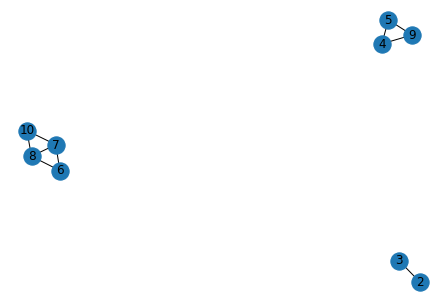

In [23]:
nx.draw(G, with_labels=True)

# Generating the output file with both Homonym and Synonym indexes

In [24]:
graph_df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

In [25]:
graph_df.head(10)

,name,short_name,publications,classified,type
2,Chang Chen,A,"[P2, P1]",True,NaN
3,Tasawar Ali,E,[P2],NaN,NaN
4,F. Ali,F,[P3],True,core
5,M. Ibrahim,G,[P3],True,NaN
6,Farman Ali,B,[P4],True,NaN
7,Shakeel Ali,D,[P4],True,core
8,M. Rehan,C,[P4],True,NaN
9,Chang Chen,A9,[P3],NaN,NaN
10,Chang Chen,A10,"[P5, P4]",NaN,NaN


In [26]:
graph_df_with_index = graph_df.drop(['short_name','classified','type'], axis=1).reset_index(drop=True)
graph_df_with_index['homosym_network_index'] = graph_df.reset_index().index

# Combining both the homonym stage result with the homonym + synonym stage result to view side-by-side
disambiguated_df = pd.merge(disambiguated_df_homonym_only,
                            graph_df_with_index.explode('publications').reset_index(drop=True),
                            on=['name','publications'],
                            how='outer').fillna('')

In [27]:
disambiguated_df.head(50)

,name,publications,homonym_network_index,homosym_network_index
0,C. Chen,P5,0,
1,Chang Chen,P2,1,0
2,Chang Chen,P1,1,0
3,Tasawar Ali,P2,2,1
4,F. Ali,P3,3,2
5,M. Ibrahim,P3,4,3
6,Farman Ali,P4,5,4
7,Shakeel Ali,P4,6,5
8,M. Rehan,P4,7,6
9,Chang Chen,P3,8,7
